In [1]:
import torch
import torchvision
import torch.utils.data as data
from torchvision import transforms
from d2l import torch as d2l

In [2]:
d2l.use_svg_display()

In [3]:
def get_fashion_mnist_labels(labels):
    text_labels=["t-shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle boot"]
    return [text_labels[int(i)]for i in labels]
#将图像数字标签转化为文字标签

In [4]:
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    axes=axes.flatten()
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            #张量图
            ax.imshow(img.numpy())
        else:
            #plt图
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [5]:
trans= transforms.ToTensor()
mnist_train=torchvision.datasets.FashionMNIST(
    root="../data",train=True,transform=trans,download=True)
mnist_test=torchvision.datasets.FashionMNIST(
    root="../data",train=False,transform=trans,download=True)
print(len(mnist_train),len(mnist_test))
print(mnist_train[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

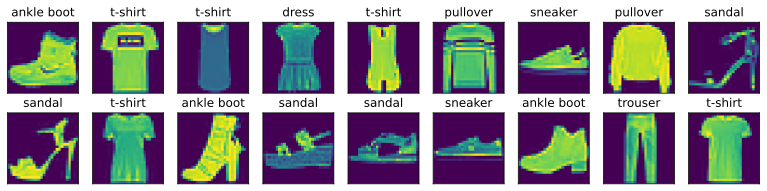

In [6]:
X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))

In [7]:
batch_size=256
def get_dataloader_workers():
    return 4
train_iter= data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())
timer=d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop():2f}sec'
#测量加载时间

'3.028761sec'

In [8]:
def load_data_fashion_mnist(batch_size,resize=None):
    trans=[transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans=transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(
        root="../data",train=True,transform=trans,download=True)
    mnist_test=torchvision.datasets.FashionMNIST(
        root="../data",train=False,transform=trans,download=True)
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=get_dataloader_workers()))

In [9]:
trian_iter,test_iter=load_data_fashion_mnist(32,resize=64)
for X,y in train_iter:
    print(X.shape,X.dtype,y.shape,y.dtype)
    break

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


In [10]:
import torch
from IPython import display 
from d2l import torch as d2l
batch_size =256
train_iter ,test_iter =d2l.load_data_fashion_mnist(batch_size)
num_inputs =28*28
num_outputs=10
W=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b= torch.zeros(num_outputs,requires_grad=True)


In [11]:
X=torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
X.sum(0,keepdim=True),X.sum(1,keepdim=True)


(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [12]:
def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition#这里运用了广播机制
#X=torch.normal(0,1,(2,5))
#X_prob=softmax(X)
#X_prob,X_prob.sum(1)

In [13]:
#定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)
y=torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y] #y_hat的0行第0列的值，1行的第2列的值

tensor([0.1000, 0.5000])

In [14]:
def cross_entropy(y_hat,y):
    return - torch.log(y_hat[range(len(y_hat)),y])
cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [15]:
#准确数函数
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
        #y_hat的形状大于1时为多分类问题，需要提取出多个概率的最大值，否则为二分类问题
    cmp=y_hat.type(y.dtype)==y
    #统计预测概率最大的类别与真实类别相同的样本总数
    return float(cmp.type(y.dtype).sum())
    #将总数转化为浮点数
accuracy(y_hat,y)/len(y)
#准确数比上总数

0.5

In [16]:
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric=Accumulator(2)#正确预测数，预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric.data[0] / metric.data[1]

In [17]:
class Accumulator:
    def __init__(self,n):
        self.data=[0.0]*n
        #初始化
    def add (self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
        #定义加法
    def reset(self):
        self.data=[0.0]*len(self.data)
        #重设参数
    def __getition__(self,idx):
        return self.data[idx]


In [18]:
evaluate_accuracy(net,test_iter)


0.097

In [19]:
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()#模型定义为训练模式
    #判断net是否为torch.nn.Module类
    metric =Accumulator(3)
    #训练损失总和，训练准确度总和，样本数
    for X,y in train_iter:
        y_hat=net(X)
        l =loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            #如果更新器为pytorch的优化器和损失函数
            updater.zero_grad()
            #清除梯度
            l.mean().backward()
            #损失函数反向传播
            updater.step()
        else:
            l.sum().backward()
            #损失函数反向传播
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric.data[0] / metric.data[2],metric.data[1] / metric.data[2]

In [20]:
class Animator:
    
    def __init__(self,xlabel=None,ylabel=None,legend=None,xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)):
        if legend is None :
            legend=[]
        d2l.use_svg_display()
        self.fig,self.axes=d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows*ncols==1:
            self.axes=[self.axes, ]
        self.config_axes=lambda:d2l.set_axes(
            self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)
        self.X,self.Y,self.fmts=None,None,fmts
    def add(self,x,y):
        if not hasattr(y,"__len__"):
            y=[y]
        n=len(y)
        if not hasattr(x,"__len__"):
            x=[x]*n
        if not self.X:
            self.X=[[] for _ in  range(n)]
        if not self.Y:
            self.Y=[[] for _ in range(n)]
        for i ,(a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y,fmt  in zip(self.X,self.Y, self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [23]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator=Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],
                     legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        #计算获得训练损失总和，训练准确度总和，样本数
        test_acc =evaluate_accuracy(net,train_iter)
        #获得预测准确率
        animator.add(epoch+1,train_metrics+(test_acc,))
    train_loss,train_acc,=train_metrics
    assert train_loss<0.5 ,train_loss
    assert train_acc <=1 and train_acc >0.7 ,train_acc
    assert test_acc<=1 and test_acc >0.7, test_acc
    

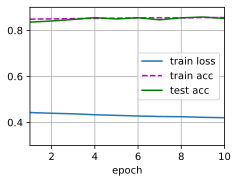

In [24]:
lr =0.1
#学习率
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)
    #用sgd的方法进行梯度下降
num_epochs=10
train_ch3(net, train_iter,test_iter,cross_entropy,num_epochs,updater)
#进行训练

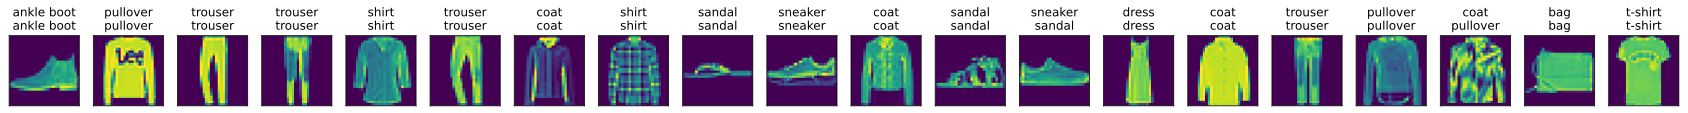

In [26]:
def predict_ch3(net,test_iter,n=20):
    for X,y in test_iter:
        break
    trues =d2l.get_fashion_mnist_labels(y)
    preds=d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles=[true+'\n'+pred for true ,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
predict_ch3(net,test_iter)

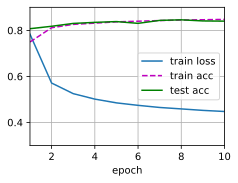

In [27]:
import torch 
from torch import nn
from d2l import torch as d2l 
batch_size =256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
net=nn.Sequential(nn.Flatten(),nn.Linear(28*28,10)) 
# 将输入图像展平为一维向量
# 全连接层，输入特征数为28*28，输出特征数为10（对应10个类别）
# 定义神经网络模型，包括一个Flatten层和一个全连接层
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights);
loss=nn.CrossEntropyLoss(reduction='none')
trainer= torch.optim.SGD(net.parameters(),lr=0.1)
num_epochs=10
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)